## Extraction of International Financial Statistics data from the International Moneraty Fund.

The International Monetary Fund's (IMF) [JSON RESTful Web Service API](https://datahelp.imf.org/knowledgebase/articles/667681-using-json-restful-web-service) allows access to macroeconomic data covering 190 countries.

In this notebook, we will explore data extraction from the International Financial Statistics (IFS) which is one of the IMF's principal datasets and has been available since 1948.<br>

The example below retrieves quarterly (period: Q) Seasonally Adjusted  Real Gross Domestic Product (indicator: NGDP_R_SA_XDC) for the USA (country code: US), from the International Financial Statistics (IFS) series. The request returns the observation values, and the time period for each value (in the format YYYY-MM-DD).<br>

The request is generated by combining the base url of the IMF API, the CompactData method, and the specific code for the series and each dimension of its data.

In order to generate datasets for multiple indices, it is necessary to find their codes. Such information is available in an Excel file with index codes and corresponding names which can be downloaded from the IMF's website at [link](https://data.imf.org/api/document/download?key=63109018) or can be viewed online using the IMF's [online data query tool](https://data.imf.org/regular.aspx?key=34426). The indices can also be searched for using the API, which will be shown below.

First, we begin with loading the necessary libraries for data extraction and data manupulation.

In [113]:
import requests, re
import pandas as pd
import json

First, we will extract GDP data for one country. Below, we specify the series name, period ('Q' or 'M' or 'A'), country code and period.

In [114]:
series = 'IFS' # International Financial Statistics
period = 'Q' # Q, M, A for quarterly, monthly or annually statistics
country = 'US' # two letter country code
time_start = 2010
time_end = 2023

To find out the index code for GDP, we will search through the available indices in the IFS dataset after specifying the index name that we are looking for.

## DataStructure method

In [115]:
search_term = 'gross domestic product'

In [116]:
key = f'DataStructure/{series}'
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'

dimension_list = requests.get(f'{url}{key}').json()['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']

key = f"CodeList/{dimension_list[2]['@codelist']}"

code_list = requests.get(f'{url}{key}').json()['Structure']['CodeLists']['CodeList']['Code']

# create a disctionary of index codes and corresponding names
code_dict = {}

for code in code_list:
    if (search_term in code['Description']['#text'].lower()):
        code_dict[code['@value']] = code['Description']['#text']

# print dictionary
code_dict

{'NGDP_D_IX': 'Gross Domestic Product, Deflator, Index',
 'NGDP_D_SA_IX': 'Gross Domestic Product, Deflator, Seasonally Adjusted, Index',
 'NGDP_XDC': 'Gross Domestic Product, Nominal, Domestic Currency',
 'NGDP_SA_XDC': 'Gross Domestic Product, Nominal, Seasonally Adjusted, Domestic Currency',
 'NGDP_NSA_XDC': 'Gross Domestic Product, Nominal, Unadjusted, Domestic Currency',
 'NGDP_R_XDC': 'Gross Domestic Product, Real, Domestic Currency',
 'NGDP_R_SA_XDC': 'Gross Domestic Product, Real, Seasonally Adjusted, Domestic Currency',
 'NGDP_R_NSA_XDC': 'Gross Domestic Product, Real, Unadjusted, Domestic Currency'}

Now, we specify the index code to extract data, eg Gross Domestic Product, Nominal, Seasonally Adjusted, Domestic Currency

In [117]:
code = 'NGDP_R_SA_XDC' # Gross Domestic Product, Real, Seasonally Adjusted, Domestic Currency

In [118]:
name = code_dict[code]

This function below returns a pandas dataframe for one index and one country.

## CompactData Method

In [119]:
def download_imf_ts(series=series, period=period, country=country, code=code, name=name, time_start=time_start, time_end=time_end):

   # building the url to access the data
    base = f'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/{series}/'
    time = f'?startPeriod={time_start}&endPeriod={time_end}'
    url = f'{base}{period}.{country}.{code}.{time}'

    # send the request
    rq = requests.get(url)
    if rq.status_code == 200:
        try:
            response = rq.json()
            series = response['CompactData']['DataSet']['Series']
            temp_dic = series.get('Obs')

            df = pd.DataFrame.from_dict(temp_dic).rename( 
                    columns = {
                        '@OBS_VALUE' : 'Value',
                        '@OBS_STATUS': 'Status'
                    }
            )
            
            # collect the necessary data into a pandas dataframe
            df['Country'] = series.get('@REF_AREA')
            df['Indicator'] = series.get('@INDICATOR')
            df['Base Year'] = series.get('@BASE_YEAR')
            df['Unit Value'] = '10e' + series.get('@UNIT_MULT') 
            df['Period'] = pd.to_datetime([row.replace('-', '') for row in df['@TIME_PERIOD']])
            df['Quarter'] = pd.PeriodIndex(df['Period'], freq='Q').astype(str)
            df.drop('@TIME_PERIOD', axis=1, inplace=True)
            df["Value"] = df["Value"].astype("double")
            df['Index name'] = name
            
            # sort values and rearrange columns
            df.sort_values(by=['Indicator', 'Country', 'Period'], axis=0, inplace=True)
            df = df[['Index name','Indicator','Base Year', 'Unit Value', 'Country', 'Period', 'Quarter', 'Value']]
        except:
            print(f"Error for {country} {code}: {url}")
            df = pd.DataFrame()
    return df

In [120]:
df = download_imf_ts(series=series, period=period, country=country, code=code, name=name, time_start=time_start, time_end=time_end)

In [121]:
df.tail(n=5)

,Index name,Indicator,Base Year,Unit Value,Country,Period,Quarter,Value
46,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2021-07-01,2021Q3,4918148.5
47,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2021-10-01,2021Q4,5001545.3
48,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-01-01,2022Q1,4981022.0
49,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-04-01,2022Q2,4973817.8
50,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-07-01,2022Q3,5005430.3


The data is available up to Q3 2021.

In [122]:
df['QoQ'] = df['Value'].pct_change()

In [123]:
df.tail(n=5)

,Index name,Indicator,Base Year,Unit Value,Country,Period,Quarter,Value,QoQ
46,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2021-07-01,2021Q3,4918148.5,0.006567
47,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2021-10-01,2021Q4,5001545.3,0.016957
48,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-01-01,2022Q1,4981022.0,-0.004103
49,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-04-01,2022Q2,4973817.8,-0.001446
50,"Gross Domestic Product, Real, Seasonally Adjus...",NGDP_R_SA_XDC,2012,10e6,US,2022-07-01,2022Q3,5005430.3,0.006356


In [124]:
import matplotlib.pyplot as plt;

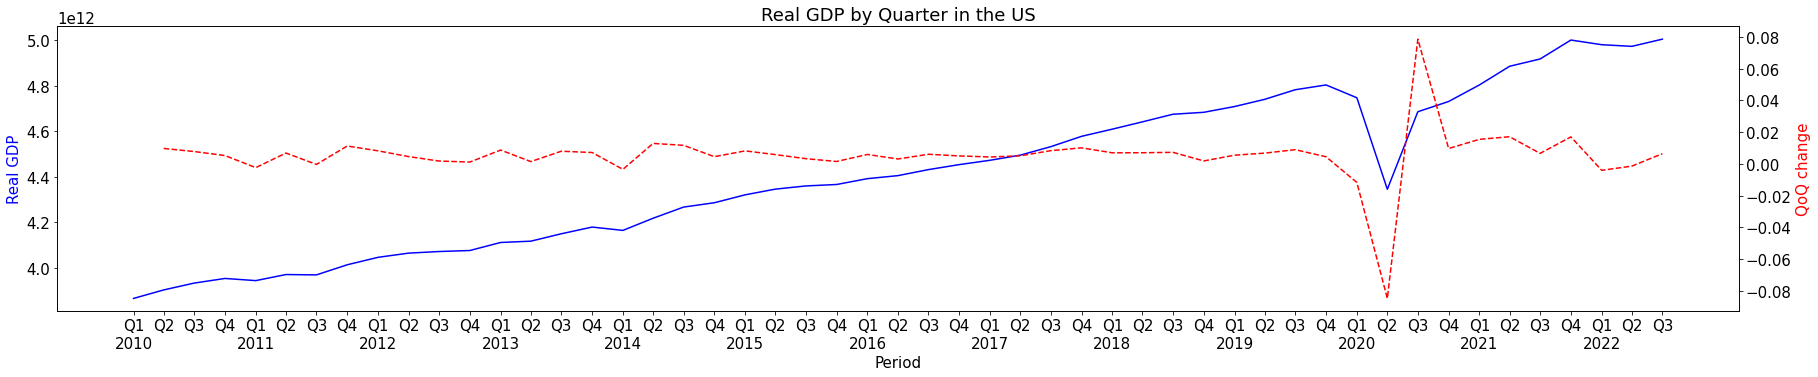

In [136]:
plt.rcParams.update({'font.size': 15})

t = df['Period']
data1 = df['Value'] * 10**6
data2 = df['QoQ']

labels = [f'Q{int(ts.month/3)+1}\n{ts.year}' if ts.month == 1
          else f'Q{int(ts.month/3)+1}' for ts in t]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Period')
ax1.set_ylabel('Real GDP', color='blue')
ax1.set_xticks(t)
ax1.set_xticklabels(labels);
ax1.plot(t, data1, color='blue')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()

ax2.set_ylabel('QoQ change', color='red')
ax2.set_xticks(t)
ax2.set_xticklabels(labels);
ax2.plot(t, data2, '--', color='red')
ax2.tick_params(axis='y', labelcolor='black')

fig.set_size_inches(25.5, 5.5)
plt.title('Real GDP by Quarter in the US')
fig.tight_layout()
plt.show()

Now, we will save the dataset to csv.

In [139]:
df.to_csv('RGDP_US_2010_2022.csv', header=True)

In this notebook, we looked at an exaple of how to retrieve data from the IMF's JSON RESTful Web Service API.